# Static plotting for `spatialdata` 

In this notebook, we will explore how to use `spatialdata-plot` to generate static plots of various different technologies. When we load the `spatialdata-plot` library, this adds the `.pl` accessor to every `SpatialData` object, which gives us access to the plotting functions. Their logic is loosly inspired by the ggplot-library in R, in which one can chain multiple function calls, gradually building the final figure.

In [3]:
import spatialdata as sd
import spatialdata_plot
import matplotlib.pyplot as plt  # for multi-panel plots later

sdata_merfish = sd.read_zarr("../data/merfish.zarr")

In particular, the library exposes the following funcitons:
- [`Spatialdata.pl.render_images()`](https://spatialdata.scverse.org/projects/plot/en/latest/plotting.html#spatialdata_plot.pl.basic.PlotAccessor.render_images)
- [`Spatialdata.pl.render_labels()`](https://spatialdata.scverse.org/projects/plot/en/latest/plotting.html#spatialdata_plot.pl.basic.PlotAccessor.render_labels)
- [`Spatialdata.pl.render_points()`](https://spatialdata.scverse.org/projects/plot/en/latest/plotting.html#spatialdata_plot.pl.basic.PlotAccessor.render_points)
- [`Spatialdata.pl.render_shapes()`](https://spatialdata.scverse.org/projects/plot/en/latest/plotting.html#spatialdata_plot.pl.basic.PlotAccessor.render_shapes)
- [`Spatialdata.pl.show()`](https://spatialdata.scverse.org/projects/plot/en/latest/plotting.html#spatialdata_plot.pl.basic.PlotAccessor.show)

We can chain the 4 `render_xxx` functions to gradually build up a figure, with a final call to `show` to then actually render out the function. In the following sections we will explore these functions further.


## Overview
- [Simple function calls](#simple-viz)
- [Stacking function calls](#stacked-viz)
- [Transformations](#transformations)
- [Best practises](#best-practises)

## Simple function calls <a id="simple-viz"></a>
Let's first focus on the [MERFISH](https://vizgen.com/technology/) data from the previous notebook. As we can see below, it contains slots for `Images`, `Points`, `Shapes`, and `Tables`.

In [4]:
sdata_merfish

SpatialData object, with associated Zarr store: /Users/tim.treis/Documents/GitHub/spatialdata-workshops/data/merfish.zarr
├── Images
│     └── 'rasterized': DataArray[cyx] (1, 522, 575)
├── Points
│     └── 'single_molecule': DataFrame with shape: (<Delayed>, 3) (2D points)
├── Shapes
│     ├── 'anatomical': GeoDataFrame shape: (6, 1) (2D shapes)
│     └── 'cells': GeoDataFrame shape: (2389, 2) (2D shapes)
└── Tables
      └── 'table': AnnData (2389, 268)
with coordinate systems:
    ▸ 'global', with elements:
        rasterized (Images), single_molecule (Points), anatomical (Shapes), cells (Shapes)

Let's first visualise the individual contained modalities separately. 

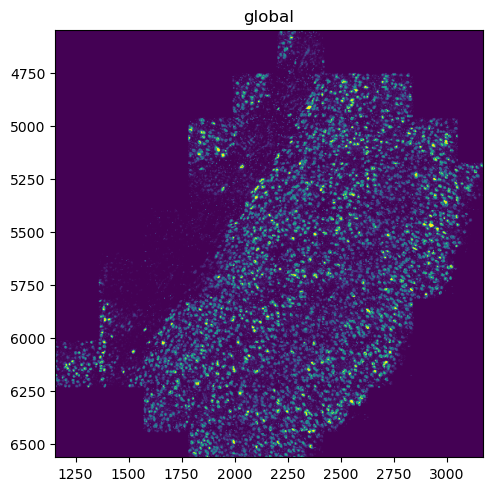

In [5]:
sdata_merfish.pl.render_images().pl.show()

/Users/tim.treis/anaconda3/envs/spatialdata/lib/python3.10/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/Users/tim.treis/anaconda3/envs/spatialdata/lib/python3.10/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/tim.treis/anaconda3/envs/spatialdata/lib/python3.10/site-packages/spatialdata/_core/_elements.py:106: UserWarning: Key `single_molecule` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)


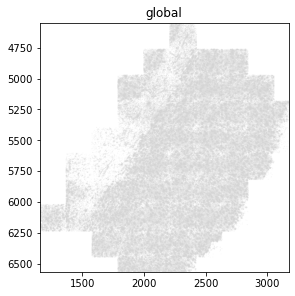

In [6]:
sdata_merfish.pl.render_points().pl.show()

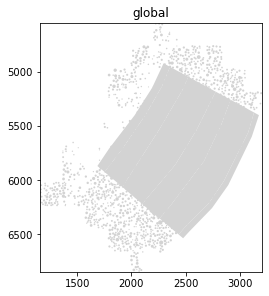

In [7]:
sdata_merfish.pl.render_shapes().pl.show()  # visualises the two shapes on top of each other since they exist in the same coordinate system "global"

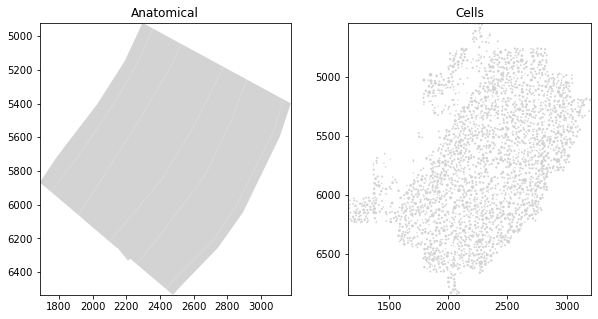

In [8]:
_, axs = plt.subplots(1, 2, figsize=(10, 5))

sdata_merfish.pl.render_shapes(element="anatomical").pl.show(ax=axs[0], title="Anatomical")
sdata_merfish.pl.render_shapes(element="cells").pl.show(ax=axs[1], title="Cells")

## Stacked function calls <a id="stacked-viz"></a>

Very similar to other matplotlib-based tools, we can also add multiple elements to the same `ax` object here. If we chain the function calls and the elements exist within the same coordinate system, this happens automatically. Based on the name of the `Shapes` object, we can already assume that the "anatomical" element contains some anatomical annotations. We will modify some visual parameters to make the individual shapes more easily.

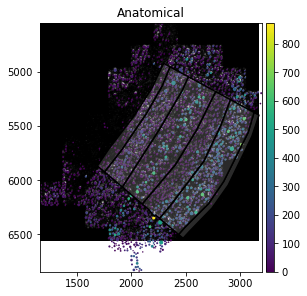

In [9]:
(
    sdata_merfish
    .pl.render_images(cmap="grey")
    .pl.render_shapes(element="cells", fill_alpha=1, color="Lamp5")
    .pl.render_shapes(element="anatomical", fill_alpha=0.2, outline=True)
    .pl.show(title="Anatomical")
)

We can appreciate, comparing with the previous plots, that the two elements are correctly overlayed. We can use further information contained in the objects to further improve this information. The contained table is an `AnnData` object. Let's inspect it.

In [10]:
sdata_merfish.tables["table"]

AnnData object with n_obs × n_vars = 2389 × 268
    obs: 'cell_id', 'region'
    uns: 'spatialdata_attrs'

The `Anndata.X` matrix itself contains the gene expression of each individual cell:

In [11]:
sdata_merfish.tables["table"].to_df()

,1700022I11Rik,1810046K07Rik,5031425F14Rik,5730522E02Rik,Acta2,Adam2,Adamts2,Adamts4,Adra1b,Alk,...,Unc5b,Unc5d,Ust,Vip,Vipr2,Vtn,Vwc2,Wipf3,Wnt7b,Zfp804b
0,0,0,0,0,0,0,0,0,1,1,...,0,0,0,328,0,0,1,0,0,0
1,0,0,1,1,0,0,0,0,0,0,...,0,0,1,0,0,0,9,1,0,1
2,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,2,0,0
3,0,0,0,0,2,0,0,0,0,0,...,0,0,0,14,0,0,3,0,0,0
4,0,0,0,1,0,0,0,2,0,0,...,0,0,1,4,0,0,4,3,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2394,0,0,0,0,3,1,0,0,0,0,...,0,1,2,2,0,0,3,2,0,0
2395,0,0,0,0,6,1,0,1,0,0,...,1,2,0,6,1,0,1,3,1,1
2396,0,1,0,1,3,2,0,3,0,0,...,1,2,2,2,1,0,8,5,0,0
2397,1,0,0,0,0,0,0,2,0,2,...,1,0,2,4,0,0,2,0,0,0


We can use this data to, for example, color a shapes object by its expression:

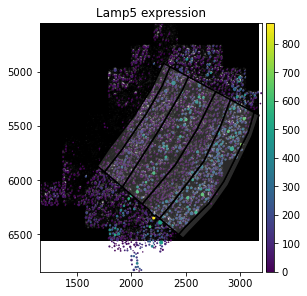

In [12]:
(
    sdata_merfish
    .pl.render_images(cmap="grey")
    .pl.render_shapes(element="cells", fill_alpha=1, color="Lamp5")
    .pl.render_shapes(element="anatomical", fill_alpha=0.2, outline=True)
    .pl.show(title="Lamp5 expression")
)

Furthermore, the `Points` object "single_molecule" is also associated with metadata, namely the celltype it was annotated to be associated with.

In [13]:
sdata_merfish["single_molecule"].compute() # this is a dask dataframe, so we need to call compute to get the actual data

,x,y,cell_type
0,1278.683956,6020.642260,outside_VISp
1,1326.970330,6023.884788,outside_VISp
2,1292.026844,6059.337093,outside_VISp
3,1300.886241,6097.786264,outside_VISp
4,1232.410068,6102.884182,outside_VISp
...,...,...,...
3714637,3161.427603,5192.594981,outside_VISp
3714638,3099.698528,5221.596008,outside_VISp
3714639,3084.582240,5297.234605,outside_VISp
3714640,3054.192051,5342.142346,VISp_II/III


Similarly, we can use these annotations to color our points:

/Users/tim.treis/anaconda3/envs/spatialdata/lib/python3.10/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/Users/tim.treis/anaconda3/envs/spatialdata/lib/python3.10/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/tim.treis/anaconda3/envs/spatialdata/lib/python3.10/site-packages/spatialdata/_core/_elements.py:106: UserWarning: Key `single_molecule` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)
/Users/tim.treis/Documents/GitHub/spatialdata-plot/src/spatialdata_plot/pl/utils.py:709: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this war

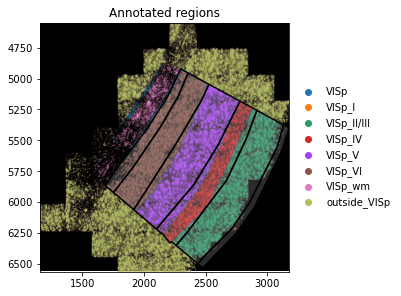

In [14]:
(
    sdata_merfish
    .pl.render_images(cmap="grey")
    .pl.render_points(color="cell_type")
    .pl.render_shapes(element="anatomical", fill_alpha=0.2, outline=True)
    .pl.show(title="Annotated regions")
)

## Transformations <a id="transformations"></a>
While this particular dataset is already (mostly) aligned correctly, we will use it to demonstrate the transformation logic of the `spatialdata` ecosystem. For the sake of this exercise, we will assume that the `Shapes` layer containing the anatomical regions needs to be adjusted to better match the "VISp_II/III" point annotation. We will use the `spatialdata` transformation logic to do so.

Using the [`spatialdata.transformations.get_transformations()`](https://spatialdata.scverse.org/en/latest/generated/spatialdata.transformations.get_transformation.html) function, we can extract the original transformation to the coordinate system it maps to:

In [24]:
orig_transform = sd.transformations.get_transformation(element=sdata_merfish["anatomical"], to_coordinate_system="global")
orig_transform

Identity 

This tells us that the `Shapes` object holding this annotation does not get transformed since its coordinates already match the underlying image. We can nontheless "nudge" it a litle bit more towards the top-left so that it better matches the point annotations. We can do this by applying a translation to the `Shapes` object:

In [30]:
translation = sd.transformations.Translation([-10, -10], axes=("x", "y"))
sd.transformations.set_transformation(sdata_merfish["anatomical"], translation, to_coordinate_system="global")

When we call the same plotting functions as before, we can see that the shapes are now "better" aligned with the points.

/Users/tim.treis/anaconda3/envs/spatialdata/lib/python3.10/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/Users/tim.treis/anaconda3/envs/spatialdata/lib/python3.10/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/tim.treis/anaconda3/envs/spatialdata/lib/python3.10/site-packages/spatialdata/_core/_elements.py:106: UserWarning: Key `single_molecule` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)
/Users/tim.treis/Documents/GitHub/spatialdata-plot/src/spatialdata_plot/pl/utils.py:709: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this war

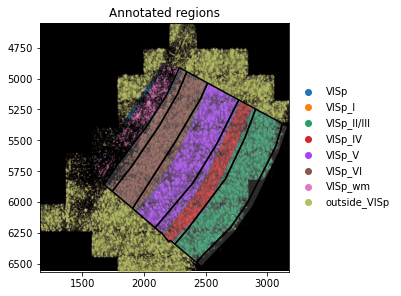

In [31]:
(
    sdata_merfish.pl.render_images(cmap="grey")
    .pl.render_points(color="cell_type")
    .pl.render_shapes(element="anatomical", fill_alpha=0.2, outline=True)
    .pl.show(title="Annotated regions")
)

## Best practises <a id="best-practises"></a>


Generally, the `spatialdata-plot` library tries to be as flexible as possible, allowing for a wide range of different plotting options. However, this flexibility comes at the cost of some complexity. To limit the amount of permutations we have to account for in the codebase, we recommend a workflow in which one gradually build up a figure on an `ax` object. If multiple similar plots are required, it is currently the easiest way, to manually assign them to their panels, for example like this:

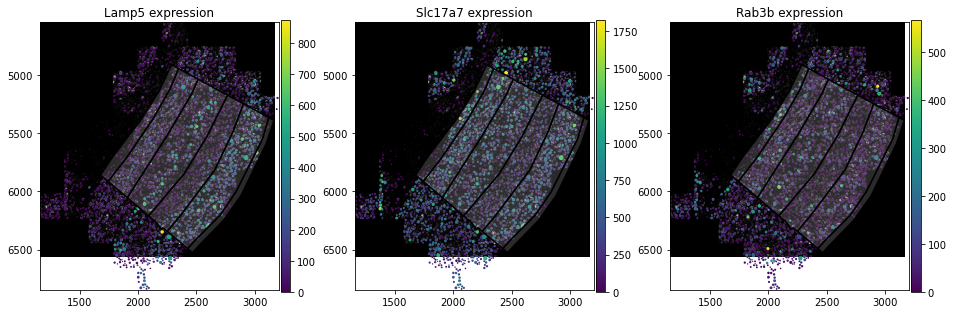

In [40]:
_, axs = plt.subplots(1, 3, figsize=(16, 5))

for idx, gene in enumerate(["Lamp5", "Slc17a7", "Rab3b"]):
    (
        sdata_merfish.pl.render_images(cmap="grey")
        .pl.render_shapes(element="cells", fill_alpha=1, color=f"{gene}")
        .pl.render_shapes(element="anatomical", fill_alpha=0.2, outline=True)
        .pl.show(title=f"{gene} expression", ax=axs[idx])
    )